# Radiation Forces in a Debris Disk

Here we add radiation forces to dust particles as a simple model for a debris disk, using WHFast.  Our radiation force implementation follows Eq. 5 from Burns et al. 1979.  It includes terms for what's typically referred to as the radiation pressure (acting radially) and Poynting-Robertson drag (acting opposite the particle's velocity).  

We imagine a Sun-like star, with debris having semimajor axes between 100-120 AU.  We have to ensure all quantities are entered in the same units--here we choose to use SI units.

In [1]:
import rebound
import reboundx
import numpy as np
sim = rebound.Simulation()
rebound.G = 6.674e-11 # SI units
sim.integrator = "whfast"
sim.dt = 1.e8 # At ~100 AU, orbital periods ~1000 yrs, so use a timestep of 1% of that, in sec.
sim.N_active = 1 # Make it so dust particles don't interact with one another gravitationally
sim.add(m=1.99e30) # add Sun with mass in kg
ps = sim.particles

Now let's set up `REBOUNDx` and add `radiation_forces`.  We also have to set the speed of light in the units we want to use.

In [2]:
rebx = reboundx.Extras(sim)
rf = rebx.load_force("radiation_forces")
rebx.add_force(rf)
rf.params["c"] = 3.e8

By default, the `radiation_forces` effect assumes the particle at index 0 is the source of the radiation.  If you'd like to use a different one, or it's possible that the radiation source might move to a different index (e.g. with a custom merger routine), you can add a `radiation_source` flag to the appropriate particle like this:

In [3]:
ps[0].params["radiation_source"] = 1

We imagine a debris disk of dust particles all with a beta parameter of 0.1 (ratio of radiation pressure force to gravitational force) that have semimajor axes uniformly distributed between 100 and 120 AU.  We initialize them all with 0.01 eccentricity, and random pericenters and azimuths.  We further consider a 10 AU vertical thickness, which for simplicity we model as a uniform random inclination between 0 and $\sin^{-1}(10AU / 100 AU)$ with random longitudes of node.

**In order for particles to feel radiation forces, we have to set their `beta` parameter**.  `beta` is tha ratio of the radiation force to the gravitational force from the star (Burns et al. 1979).  Here we simply set all particles' `beta` parameter to 0.1, but one can easily consider a size distribution of particles, and calculate `beta` from physical parameters (see [Radiation_Forces_Circumplanetary_Dust.ipynb](Radiation_Forces_Circumplanetary_Dust.ipynb)).

In [4]:
AU = 1.5e11 # in m
amin = 100.*AU
awidth = 20.*AU
e = 0.01
incmax = np.arcsin(0.1)

beta = 0.1
Ndust = 1000

import random
seed = 3
random.seed(seed)

for i in range(1,Ndust+1):
    a = amin + awidth*random.random() # Semimajor axis
    pomega = 2*np.pi*random.random()  # Longitude of pericenter
    f = 2*np.pi*random.random()       # True anomaly
    Omega = 2*np.pi*random.random()   # Longitude of node
    inc = incmax*random.random()      # Inclination
    sim.add(a=a, e=e, inc=inc, Omega=Omega, pomega=pomega, f=f)
    sim.particles[i].beta = beta

Now we would run our REBOUND simulation as usual.  Let's check that our disk looks how we'd expect:

Text(0.5,1,'Edge-on view')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


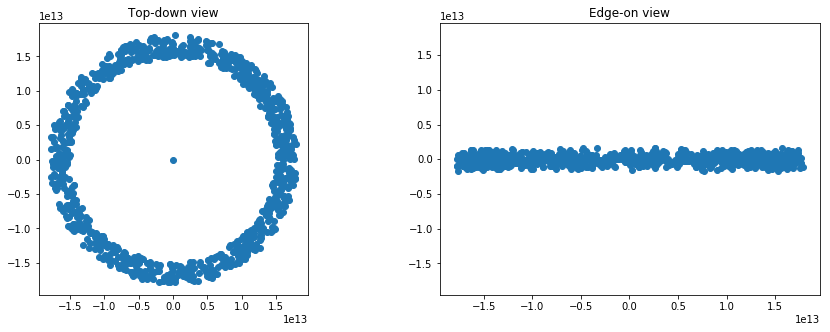

In [5]:
xs = [ps[i].x for i in range(sim.N)]
ys = [ps[i].y for i in range(sim.N)]
zs = [ps[i].z for i in range(sim.N)]

%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.scatter(xs, ys)
ax1.set_aspect('equal')
ax1.set_title('Top-down view')
ax2.scatter(xs, zs)
ax2.set_ylim(ax2.get_xlim())
ax2.set_title('Edge-on view')